# Machine Learning Exercise 13

# Transfer Learning - ARGOS 

This exercise shows how to apply transfer learning from ImageNet to ARGOS domain.


##Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
import numpy as np
import tensorflow as tf

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.7.0
Found GPU at: /device:GPU:0


## Load data

Get data from 
https://drive.google.com/drive/folders/0Bxxqx_AAp2u2Zkp4cGxoNVEzb3M?resourcekey=0-RKOYOxuHZTxh0eSZRSnIoA

Place data in a Google folder and set the datadir variable below with the path of this folder.

Get Google Drive access

Load training data

4774 images from 20 classes



In [ ]:
import os
from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt
import pickle 



drive.mount('/content/drive')

datadir = '/content/drive/My Drive/Data/ARGOS_public'
trainingset = datadir+'/train/'
testset = datadir + '/test/'
models_dir = datadir + '/models/'
results_dir = datadir + '/results/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved on file %s\n" %filename)

def savehistory(history,problem):
    filename = os.path.join(results_dir, '%s.hist' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    print("\nHystory saved on file %s\n" %filename)

def loadhistory(problem):
    filename = os.path.join(results_dir, '%s.hist' %problem)
    with open(filename, 'rb') as f:
        history = pickle.load(f)
    print("\nHystory loaded from file %s\n" %filename)
    return history


# level of data augmentation [0: none, 1: low, 2: high ]
data_augmentation_level = 2

batch_size = 64
input_shape = ()

if data_augmentation_level==0:

    train_datagen = ImageDataGenerator(
        rescale = 1. / 255)
    train_shuffle = False

elif data_augmentation_level==1:

    train_datagen = ImageDataGenerator(
        rescale = 1. / 255,\
        zoom_range=0.1,\
        rotation_range=10)
    train_shuffle = False

else:    
    train_datagen = ImageDataGenerator(
        rescale = 1. / 255,\
        zoom_range=0.1,\
        rotation_range=20,\
        width_shift_range=0.1,\
        height_shift_range=0.1,\
        horizontal_flip=True,\
        vertical_flip=False)
    train_shuffle = True

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=train_shuffle)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

print('Data augmentation level: %d' %(data_augmentation_level))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4774 images belonging to 20 classes.
Found 1686 images belonging to 20 classes.
Image input (118, 224, 3)
Classes: ['Acqua', 'Alilaguna', 'Ambulanza', 'Barchino', 'Cacciapesca', 'Caorlina', 'Gondola', 'Lancia', 'Motobarca', 'Motopontonerettangolare', 'MotoscafoACTV', 'Mototopo', 'Patanella', 'Polizia', 'Raccoltarifiuti', 'Sandoloaremi', 'Sanpierota', 'Topa', 'VaporettoACTV', 'VigilidelFuoco']
Loaded 4774 training samples from 20 classes.
Loaded 1686 test samples from 20 classes.
Data augmentation level: 2


## Show random image



VaporettoACTV


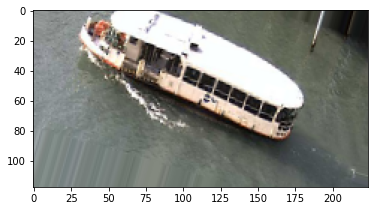

Mototopo


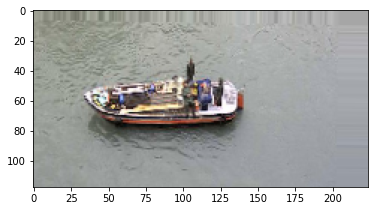

VaporettoACTV


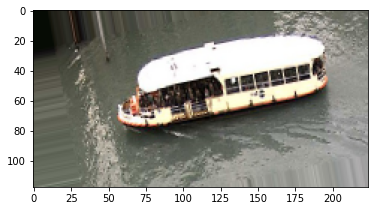

In [ ]:
n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()


## Load base VGG16 model

Load VGG16 model pre-trained with ImageNet

In [ ]:
# Load VGG16 model 
# init_weights='imagenet' if you want to use the pretrained model
def load_vgg16_features(input_shape, init_weights=None):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load VGG16 model (possibly pretrained model on imagenet) without the final dense layers (include_top=False)
    vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = tf.keras.models.Model(inputs=input0, outputs=vgg16_model.output, name="vgg16_features")

    optimizer = 'adam' #alternative 'sgd'

    feature_extractor.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

vgg16feat_model = load_vgg16_features(input_shape)
vgg16feat_model.summary()


Model: "vgg16_features"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 118, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 118, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 118, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 59, 112, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 59, 112, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 59, 112, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 29, 56, 128)    

##VGG16-TransferNet

Transfer learning from VGG16 trained on ImageNet

In [ ]:
def transferNet(input_shape, num_classes, output_layer_name, trainable_layers):
    
    # load the pre-trained model
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')

    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # add a Dense layer
    dense1 = Dropout(0.4)(flatten_norm)
    dense1 = Dense(200, activation='relu')(dense1)
    dense1 = BatchNormalization()(dense1)
    
    # add a Dense layer
    dense2 = Dropout(0.4)(dense1)
    dense2 = Dense(100, activation='relu')(dense2)
    dense2 = BatchNormalization()(dense2)

    # add the final output layer
    dense3 = BatchNormalization()(dense2)
    dense3 = Dense(num_classes, activation='softmax')(dense3)
    
    model = tf.keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model



# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

# build the transfer model
transfer_model = transferNet(input_shape, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "transferNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 118, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 118, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 118, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 59, 112, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 59, 112, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 59, 112, 128)      147584    
                                                        

### Train VGG16-ARGOS

In [ ]:
# fit the transferNet on the training data
stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

epochs = 10
try:
    transfer_history = transfer_model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


# Save trained model and hystory
problemname = 'VGG16-transfer-ARGOS-10ep_NEW'
savemodel(transfer_model,problemname)
savehistory(transfer_history,problemname)


Epoch 1/10
74/74 [==============================] - 1588s 21s/step - loss: 1.1304 - accuracy: 0.7040 - val_loss: 1.2992 - val_accuracy: 0.6495
Epoch 2/10
74/74 [==============================] - 72s 976ms/step - loss: 0.6887 - accuracy: 0.8004 - val_loss: 0.4970 - val_accuracy: 0.8654
Epoch 3/10
74/74 [==============================] - 73s 990ms/step - loss: 0.5705 - accuracy: 0.8276 - val_loss: 0.3925 - val_accuracy: 0.8855
Epoch 4/10
74/74 [==============================] - 70s 951ms/step - loss: 0.5011 - accuracy: 0.8473 - val_loss: 0.4023 - val_accuracy: 0.8784
Epoch 5/10
74/74 [==============================] - 74s 1s/step - loss: 0.4548 - accuracy: 0.8565 - val_loss: 0.3988 - val_accuracy: 0.8849
Epoch 6/10
74/74 [==============================] - 72s 973ms/step - loss: 0.4121 - accuracy: 0.8705 - val_loss: 0.4434 - val_accuracy: 0.8648

Model saved on file /content/drive/My Drive/Data/ARGOS_public/models/VGG16-transfer-ARGOS-10ep_NEW.h5


Hystory saved on file /content/drive/My 

## VGG16-ShallowNet

Use VGG16 features trained on ImageNet as input for a simple classifier based on Shallow NN

In [ ]:
# define a shallow neural net
def shallowNet(input_shape, num_classes):

    # load the pre-trained model
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')

    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
        layer.trainable = False

    # get the last tensor from the feature extractor
    output_extractor = feature_extractor.output
    
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)
    
    # add the final output layer
    dense = Dense(num_classes, activation='softmax')(flatten_norm)
    

    shallow_model = Model(inputs=input_t, outputs=dense, name="shallowNet")
    
    
    optimizer = 'adam' #alternative 'SGD'
    shallow_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
    return shallow_model


shallow_model = shallowNet(input_shape, num_classes)
shallow_model.summary()

Model: "shallowNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 118, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 118, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 118, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 59, 112, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 59, 112, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 59, 112, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 29, 56, 128)       0

### Train ShallowNet

In [ ]:
# train the shallow model
stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

epochs = 10
try:
    shallow_history = shallow_model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

# Save trained model and hystory
problemname = 'VGG16-features-ShallowNN-ARGOS-10ep_NEW'
savemodel(shallow_model,problemname)
savehistory(shallow_history,problemname)

Epoch 1/10
74/74 [==============================] - 1542s 21s/step - loss: 1.0057 - accuracy: 0.7331 - val_loss: 1.1716 - val_accuracy: 0.7070
Epoch 2/10
74/74 [==============================] - 67s 900ms/step - loss: 0.5921 - accuracy: 0.8325 - val_loss: 0.6915 - val_accuracy: 0.8327
Epoch 3/10
74/74 [==============================] - 70s 941ms/step - loss: 0.5097 - accuracy: 0.8535 - val_loss: 0.5046 - val_accuracy: 0.8553
Epoch 4/10
74/74 [==============================] - 70s 939ms/step - loss: 0.4511 - accuracy: 0.8658 - val_loss: 0.4980 - val_accuracy: 0.8594
Epoch 5/10
74/74 [==============================] - 68s 920ms/step - loss: 0.4103 - accuracy: 0.8777 - val_loss: 0.4659 - val_accuracy: 0.8873
Epoch 6/10
74/74 [==============================] - 70s 941ms/step - loss: 0.3846 - accuracy: 0.8877 - val_loss: 0.5045 - val_accuracy: 0.8772
Epoch 7/10
74/74 [==============================] - 66s 898ms/step - loss: 0.3732 - accuracy: 0.8902 - val_loss: 0.5356 - val_accuracy: 0.8837

## VGG16-SVM

Use VGG16 features to train an SVM model.

In [ ]:
# Load VGG16 pre-trained on Image Net
vgg16feat_model = load_vgg16_features(input_shape, init_weights='imagenet')


Reshape data

In [ ]:
def rescale(x):
  x = x / 255.
  return x

# image flow of training samples from directory (without augmentation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  trainingset,
  image_size=(118, 224),
  label_mode='categorical',
  batch_size=batch_size,
  shuffle=False)

print('Creating cache for training images... it takes several minutes....')
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# re-scale images to 0-1 range
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
train_ds = train_ds.repeat(1)

# extract training features
x_feat = vgg16feat_model.predict(train_ds)

# global average pool on training features
x_feat_resh = np.mean(x_feat, axis=(1,2))
#x_feat_resh = np.reshape(x_feat, (x_feat.shape[0],-1))

# extract testing features
x_feat_test = vgg16feat_model.predict(test_generator)

# global average pool on testing features
#x_feat_test_resh = np.reshape(x_feat_test, (x_feat_test.shape[0],-1))
x_feat_test_resh = np.mean(x_feat_test, axis=(1,2))

# get the training/test labels
y_train = []
y_test = []

# image flow of testing samples from directory 
# we can't directly use the previously instantiated testing flow-from_diretory because of bug
# loops indefinetely if used with for loop (https://github.com/keras-team/keras-preprocessing/issues/45)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testset,
  image_size=(118, 224),
  label_mode='categorical',
  batch_size=batch_size,
  shuffle=False)

print('Creating cache for testing images... it takes several minutes....')
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# re-scale images to 0-1 range
test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.repeat(1)

# get the training/testing labels (sklearn format)
y_train = [y_b for _, y_b in train_ds]
y_test = [y_b for _, y_b in test_ds]

y_train = np.concatenate(y_train, axis=0)
y_test = np.concatenate(y_test, axis=0)

y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)


Found 4774 files belonging to 20 classes.
Creating cache for training images... it takes several minutes....
Found 1686 files belonging to 20 classes.
Creating cache for testing images... it takes several minutes....


Train and evaluate SVM model

In [ ]:
from sklearn import svm

kernel_name  = 'linear' # 'linear', 'poly', 'rbf', 'sigmoid'
C = 1

classifier = svm.SVC(C=C, kernel=kernel_name, degree=3, gamma="scale")
classifier.fit(x_feat_resh,y_train)

svm_acc = classifier.score(x_feat_test_resh, y_test)    
print("Accuracy %.3f" %svm_acc)

Accuracy 0.881


##Plot results


Hystory loaded from file /content/drive/My Drive/Data/ARGOS_public/results/VGG16-transfer-ARGOS-10ep_NEW.hist


Hystory loaded from file /content/drive/My Drive/Data/ARGOS_public/results/VGG16-features-ShallowNN-ARGOS-10ep_NEW.hist



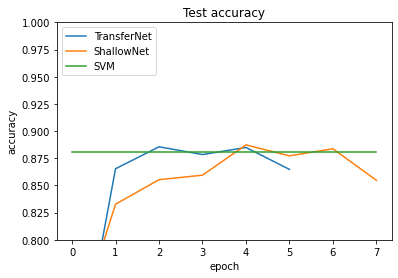

In [ ]:
import matplotlib.pyplot as plt

def plot_results(histories,legend):

    plt.title('Test accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.8,1.0)
    for h in histories:
        plt.plot(h)
    plt.legend(legend, loc='upper left')
    plt.show()



svm_acc = 0.881  # linear kernel C=1
transfer_history = loadhistory('VGG16-transfer-ARGOS-10ep_NEW')
shallow_history = loadhistory('VGG16-features-ShallowNN-ARGOS-10ep_NEW')
svm_hist = [svm_acc for _ in range(len(shallow_history['val_accuracy']))]


legend = ["TransferNet", "ShallowNet", "SVM"]
histories = [transfer_history['val_accuracy'], shallow_history['val_accuracy'], svm_hist]
plot_results(histories,legend)

